# Time-series search with TSPulse Register Embeddings - Zero-Shot Performance

Time-series search is a valuable technique for analyzing data patterns over time.
One situation where it can be useful is when there is a sudden spike or drop in the data.
In such cases, checking whether similar patterns have occurred in the past can provide useful context for understanding the current situation.
By identifying historical data that exhibit similar patterns, time-series search helps uncover various patterns such as recurring trends and repeated anomalies in specific sensors.

[TSPulse](https://huggingface.co/ibm-granite/granite-timeseries-tspulse-r1) is provided as a pre-trained model, allowing users to start using it immediately.
In addition, TSPulse time-series search offers an efficient way to identify similar patterns in time-series data.
It effectively addresses several challenges often encountered in real-world datasets:
- Temporal shifts: It can detect similar patterns even if they occur slightly earlier or later in time.
- Scale differences: It recognizes patterns regardless of whether one instance is larger or smaller than another.
- Noise tolerance: It performs reliably even when the data contains minor fluctuations or random noise.

This notebook provides a demonstration of how to use TSPulse time-series search with a dataset for time-series classification.
The dataset consists of multiple examples, each labeled with a category.
TSPulse transforms each example into a compact representation known as an embedding, which captures the essential characteristics of data.
To perform a time-series search, we first construct an index set by computing embeddings for a collection of historical time-series data.
When a new time-series is provided as a query, we compute similarity scores between the query and the indexed historical data, and retrieve several similar time series from the index set.
Finally, we visualize the results to demonstrate the effectiveness and practical utility of time-series search.

## Setting Up
### Install the TSFM Library
The [granite-tsfm](https://github.com/ibm-granite/granite-tsfm) library provides utilities for working with Time Series Foundation Models (TSFM).
Here we install the latest version of the library.

In [ ]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.3.1"
! pip install "granite-tsfm[notebooks]==0.3.3" "pandas<3"

## Import Packages
From tsfm_public, we use the TSPulse model and utility functions for time-series search.

In [ ]:
import os
import requests
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import set_seed

from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.models.tspulse.utils.helpers import get_embeddings
from tsfm_public.toolkit.dataset import ClassificationDFDataset
from tsfm_public.toolkit.time_series_classification_preprocessor import (
    TimeSeriesClassificationPreprocessor,
)
from tsfm_public.toolkit.util import convert_tsfile_to_dataframe

## Specify Configuration Variables
The context length (in time steps) is set to match the pretrained model.
Additionally, we declare the Granite Time Series Model and the specific revision that we are targeting.

The granite-timeseries TSPulse card provides several different revisions of the model for downstream tasks.
In this example we focus on time-series search, so we choose a model revision suitable for that resolution.

In [ ]:
set_seed(42)

context_length = 512

TSPULSE_MODEL_PATH = "ibm-granite/granite-timeseries-tspulse-r1"
REVISION = "tspulse-hybrid-dualhead-512-p8-r1"
batch_size = 128

# top-k search
k = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = TSPulseForReconstruction.from_pretrained(
    TSPULSE_MODEL_PATH,
    revision=REVISION,
    num_input_channels=1,
    mask_type="user",
)

## Downloading the Data
We download the [ShapesAll](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/) dataset from the UCR Time Series Classification Archive.

In [ ]:
zip_url = "http://www.timeseriesclassification.com/aeon-toolkit/Archives/Univariate2018_ts.zip"
zip_path = "Univariate2018_ts.zip"
extract_dir = "Univariate_ts"

if not os.path.isdir(extract_dir):
    response = requests.get(zip_url)
    with open(zip_path, "wb") as f:
        f.write(response.content)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

    print("Data download and extraction completed successfully.")
else:
    print("Skipped: data already exists.")

## Loading the Data and Preparing the Dataset class

This cell loads and preprocesses the time series dataset for a given split (TRAIN or TEST).
The function reads a `.ts` file, converts it into a DataFrame, and then applies [TimeSeriesClassificationPreprocessor](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/time_series_classification_preprocessor.py#L27) to normalize the data.
For the test data, normalization is performed using the trained preprocessor.
The processed data is then wrapped in a [ClassificationDFDataset](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/dataset.py#L1085), which formats it for model consumption using parameters such as context length, stride, and padding.

In [ ]:
def get_data(split, tsp=None):
    df_base = convert_tsfile_to_dataframe(
        f"Univariate_ts/ShapesAll/ShapesAll_{split}.ts",
        return_separate_X_and_y=False,
    )
    label_column = "class_vals"
    input_columns = [f"dim_{i}" for i in range(df_base.shape[1] - 1)]

    if tsp is None:
        tsp = TimeSeriesClassificationPreprocessor(
            input_columns=input_columns,
            label_column=label_column,
            scaling=True,
        )
        tsp.train(df_base)

    df_prep = tsp.preprocess(df_base)
    base_dataset = ClassificationDFDataset(
        df_prep,
        id_columns=[],
        timestamp_column=None,
        input_columns=input_columns,
        label_column=label_column,
        context_length=context_length,
        static_categorical_columns=[],
        stride=1,
        enable_padding=False,
        full_series=True,
    )
    return base_dataset, tsp


train_dataset, tsp = get_data("TRAIN")
test_dataset, _ = get_data("TEST", tsp)
len(train_dataset), len(test_dataset)

## Embedding Computation and Indexing for Nearest Neighbor Search

TSPulse computes compact representations, technically known as register embeddings, that capture the semantic content of time series data.
We construct an index set composed of embeddings from previously observed time series.
To do this, we use `NearestNeighbors` to build the index set.

In [ ]:
# compute embeddings for train dataset
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
embeddings = []
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloader, total=len(dataloader))):
        embs = get_embeddings(model, batch["past_values"])
        embeddings.append(embs.numpy())
train_embeddings = np.concatenate(embeddings).squeeze(axis=1)  # squeeze because of the univariate time-series
print(train_embeddings.shape)

# create index set of embeddings
nn = NearestNeighbors(metric="l2")
nn.fit(train_embeddings)

## Search and evaluation

The search performance is evaluated using Precision@k (PREC@k).
We treat examples in the test dataset as queries and compute their embedding using TSPulse.
For each query, we retrieve the top-$k$ similar time series from the index set using nearest neighbors.
The class labels of the query and retrieved time series are then compared.
The evaluation score is reported as PREC@k.

In [ ]:
def calc_precision_k(cmp, k):
    cmp_k = np.sum(cmp[:, :k], axis=1) / k
    mean_cmp_k = np.mean(cmp_k)
    return mean_cmp_k, cmp_k


dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
cmp, I_all = [], []
with torch.no_grad():
    for batch in tqdm(dataloader):
        test_embeddings = get_embeddings(model, batch["past_values"])
        D, I = nn.kneighbors(test_embeddings.squeeze(axis=1), n_neighbors=k)
        I_all.append(I)

        label_test = batch["target_values"].numpy()
        retrieved_label = np.array([[train_dataset[i]["target_values"] for i in _I] for _I in I])
        cmp.append(label_test[:, None] == retrieved_label)

I_all = np.concatenate(I_all, axis=0)  # for visualization
cmp = np.concatenate(cmp, axis=0)
prec_k, prec_k_each = calc_precision_k(cmp, k)
print(f"PREC@{k}={prec_k:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.26it/s]

PREC@3=0.722


## Visualizing Query and Top-k Retrieved Time Series

Finally, we visualize the search performance by plotting each query alongside its top-$k$ retrieved time series.
For each query, if the class labels match, the plot background is highlighted in light green.
Overall, the search results show reasonable accuracy.

Focusing on the second row, we observe that the first half of the query time series corresponds to the second half of the second match, and vice versa.
This indicates that even when the positions of patterns within the time series are shifted, the TSPulse embedding can robustly capture the semantic features.

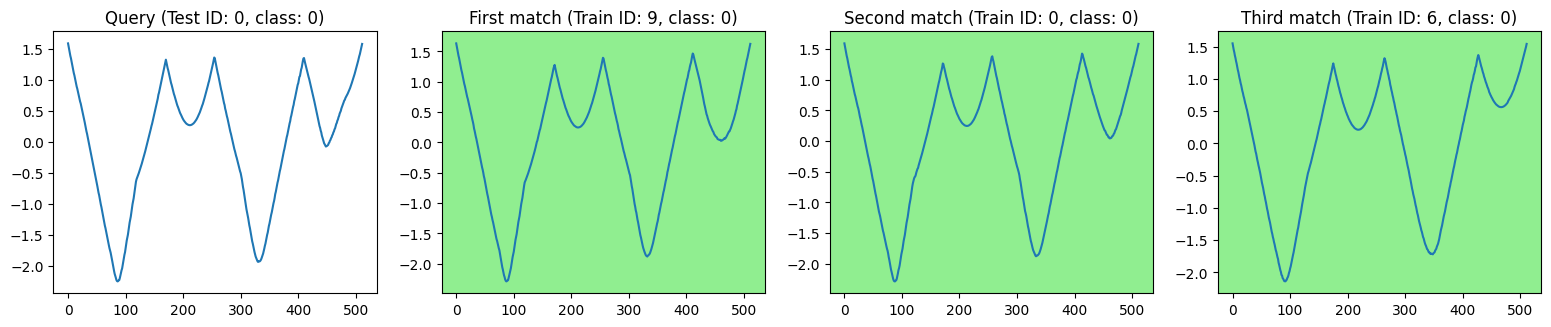

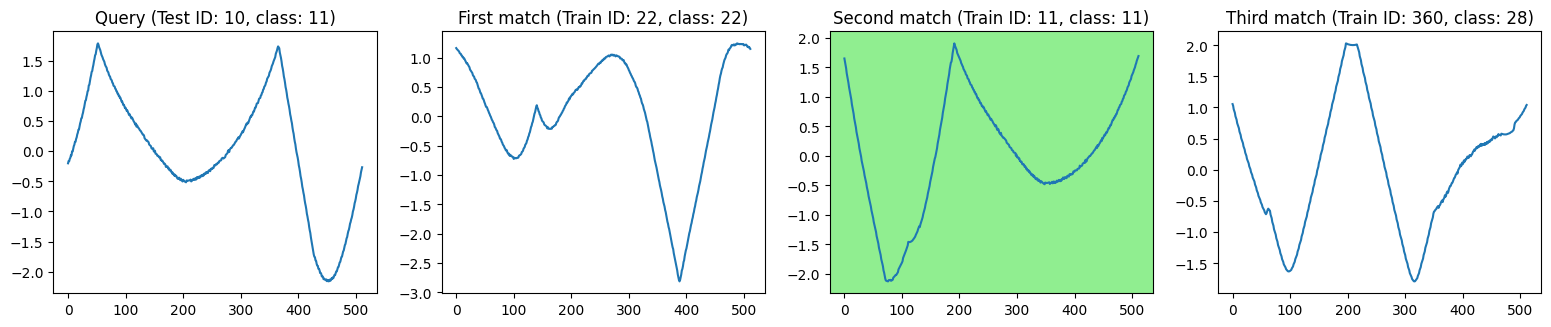

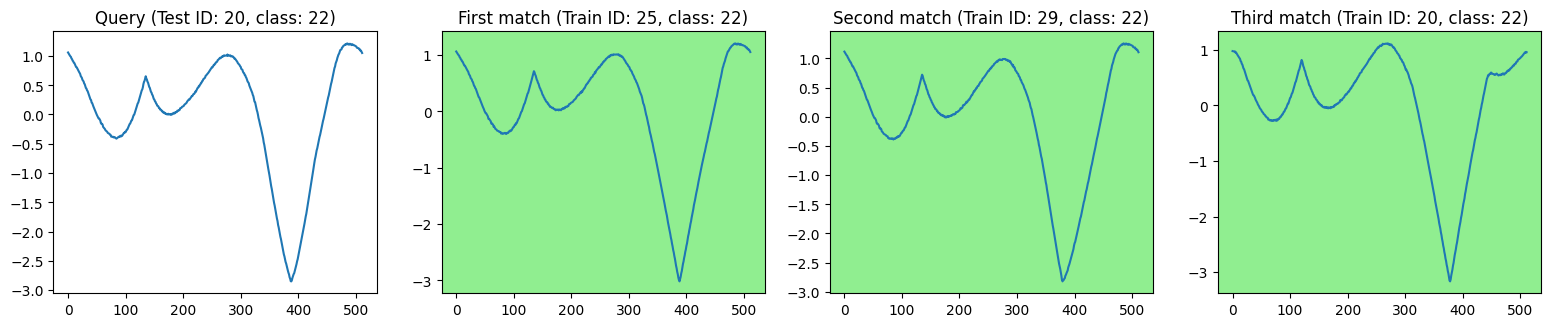

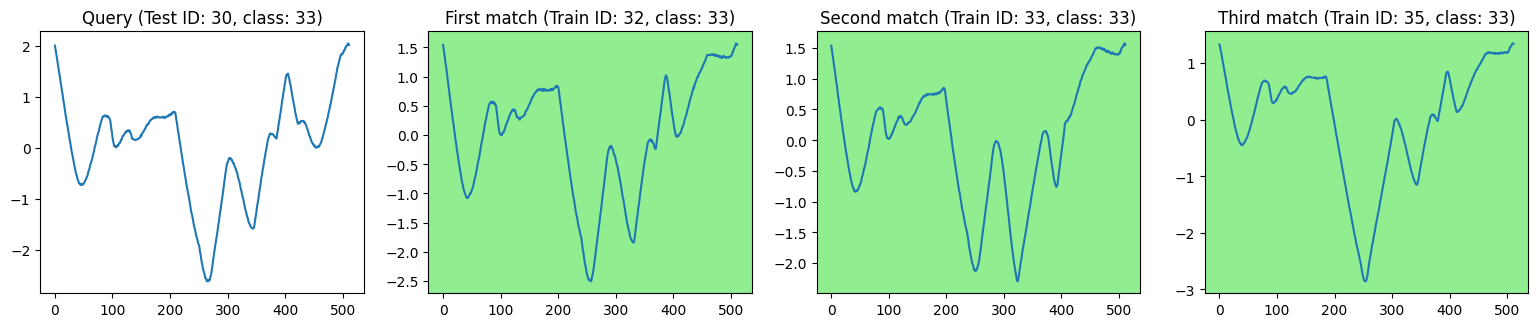

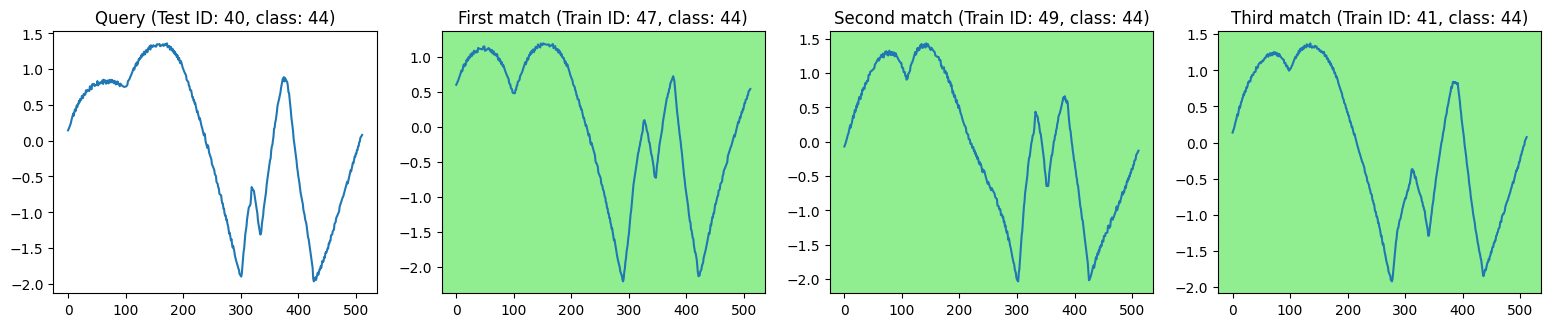

In [ ]:
plotted_list = []
for sample_idx, sample in enumerate(test_dataset):
    if sample["target_values"] in plotted_list:
        continue
    elif len(plotted_list) >= 5:  # plot max five classes
        break
    else:
        plotted_list.append(sample["target_values"])

    first_match = I_all[sample_idx][0]
    second_match = I_all[sample_idx][1]
    third_match = I_all[sample_idx][2]

    label = test_dataset[sample_idx]["target_values"]
    first_label = train_dataset[first_match]["target_values"]
    second_label = train_dataset[second_match]["target_values"]
    third_label = train_dataset[third_match]["target_values"]

    fig, ax = plt.subplots(1, 4, figsize=(6.4 * 3, 3.4))
    ax[0].plot(test_dataset[sample_idx]["past_values"])
    ax[0].set_title(f"Query (Test ID: {sample_idx}, class: {label})")

    ax[1].plot(train_dataset[first_match]["past_values"])
    ax[1].set_title(f"First match (Train ID: {first_match}, class: {first_label})")
    ax[1].set_facecolor("lightgreen") if label == first_label else None

    ax[2].plot(train_dataset[second_match]["past_values"])
    ax[2].set_title(f"Second match (Train ID: {second_match}, class: {second_label})")
    ax[2].set_facecolor("lightgreen") if label == second_label else None

    ax[3].plot(train_dataset[third_match]["past_values"])
    ax[3].set_title(f"Third match (Train ID: {third_match}, class: {third_label})")
    ax[3].set_facecolor("lightgreen") if label == third_label else None

## Links
- Library: [Granite TSFM on Github](https://github.com/ibm-granite/granite-tsfm)
- Model: [TSPulse on HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-tspulse-r1)
- Dataset: [ShapesAll from UCR Time Series Classification Archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/)